© 2025 WaLSA Team - Shahin Jafarzadeh et al.

This notebook is part of the [WaLSAtools](https://github.com/WaLSAteam/WaLSAtools) package (v1.0.0), provided under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0).

You may use, modify, and distribute this notebook and its contents under the terms of the license.

---

**Important Note on Figures**:
Figures generated using this notebook that are **identical to or derivative of those published in**:  
**Jafarzadeh, S., Jess, D. B., Stangalini, M. et al. 2025, Nature Reviews Methods Primers, in press**,  
are copyrighted by ***Nature Reviews Methods Primers***. Any reuse of such figures requires explicit permission from the journal.

Figures that are newly created, modified, or unrelated to the published article may be used under the terms of the Apache License.

---

**Disclaimer**:
This notebook and its code are provided "as is", without warranty of any kind, express or implied. Refer to the license for more details.

In [1]:
import numpy as np # type: ignore
from astropy.io import fits # type: ignore

# Load synthetic data
data_dir = 'Synthetic_Data/'

hdul = fits.open(data_dir + 'NRMP_signal_3D.fits')
signal_3d = hdul[0].data  # 3D synthetic signal data
hdul.close()

cadence = 0.5  # cadence in seconds

# Load k-omega parameters calculated and saved in FIGS4__komega_analysis.ipynb
ko_data = np.load('Saved_Parameters/k_omega_analysis.npz')

power = ko_data['power']
wavenumber = ko_data['wavenumber']
frequencies = ko_data['frequencies'] 
filtered_cube = ko_data['filtered_cube']
f1 = ko_data['f1']
f2 = ko_data['f2']
k1 = ko_data['k1']
k2 = ko_data['k2']

# Load POD parameters calculated and saved in FIGS5_FIGS6_FIGS7__POD.ipynb
pod_modes = fits.getdata('Saved_Parameters/pod_first_6_spatial_modes.fits')
frequency_filtered_modes = fits.getdata('Saved_Parameters/POD_first_6_frequency_filtered_spatial_modes_at_500mHz.fits')

GPL Ghostscript 10.04.0 (2024-09-18)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
PDF saved in CMYK format as 'Figures/Fig5_k-omega_and_pod_analyses.pdf'


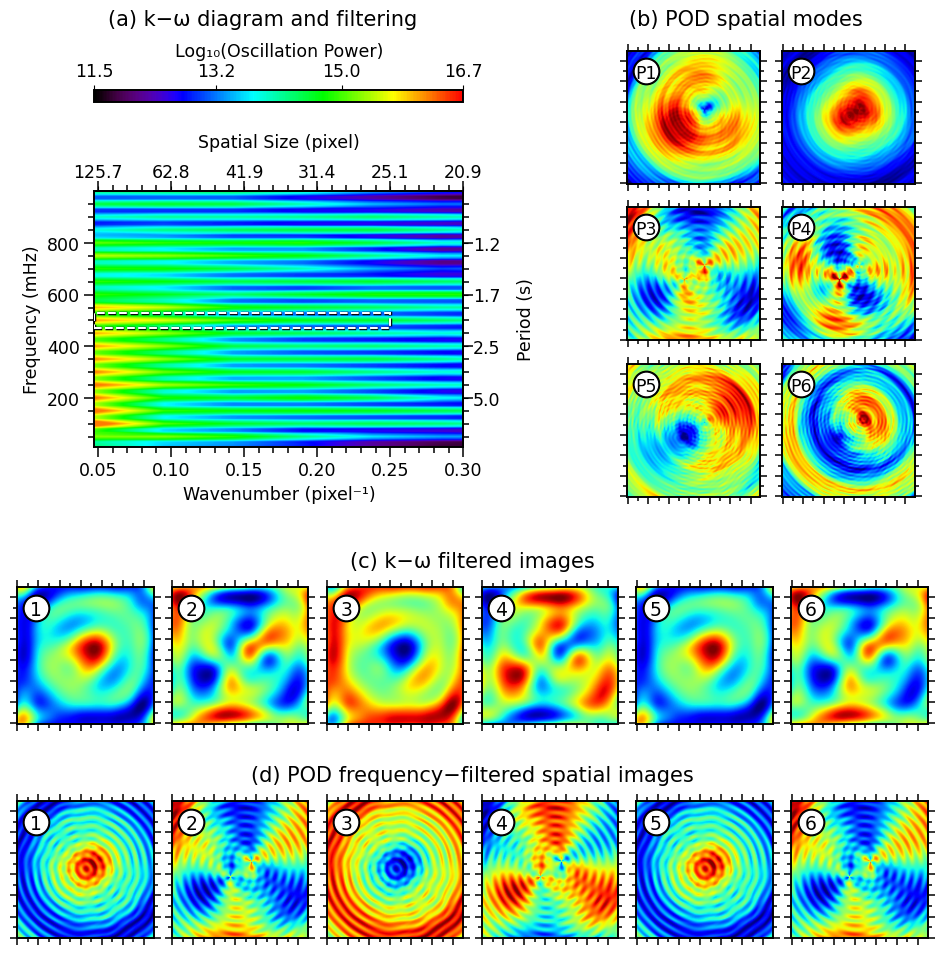

In [ ]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from matplotlib.ticker import AutoMinorLocator # type: ignore
from WaLSAtools import WaLSA_save_pdf, WaLSA_histo_opt, WaLSA_plot_k_omega # type: ignore

#------------------------------------------------------------------------------------
def calculate_grid_positions(left=0.05, bottom=0.05, h_distance=0.02, v_distance=0.02, 
                             nrows=3, ncols=2, width=None, height=None, right=None, top=None):
    """
    Calculate positions for a grid of subplots.
    
    Parameters:
    - left (float): x position of the entire grid block (0 to 1)
    - bottom (float): y position of the entire grid block (0 to 1)
    - h_distance (float): horizontal distance between plots (0 to 1)
    - v_distance (float): vertical distance between plots (0 to 1)
    - nrows (int): number of rows in the grid
    - ncols (int): number of columns in the grid
    - width (float): total width of the grid block (optional, overrides right)
    - height (float): total height of the grid block (optional, overrides top)
    - right (float): x position of the right edge of the grid block (optional)
    - top (float): y position of the top edge of the grid block (optional)
    
    Returns:
    - List of positions for each subplot in [left, bottom, width, height] format.
    """
    # If width is not provided, calculate it using 'right' or fallback to previous logic
    if width is None:
        if right is not None:
            width = right - left
        else:
            width = 1 - left - h_distance * (ncols - 1)  # Default calculation

    # If height is not provided, calculate it using 'top' or fallback to previous logic
    if height is None:
        if top is not None:
            height = top - bottom
        else:
            height = 1 - bottom - v_distance * (nrows - 1)  # Default calculation

    if width <= 0 or height <= 0:
        raise ValueError("Both 'width' and 'height' must be positive values.")

    # Calculate the available width and height for subplots (account for distances)
    total_width = width - h_distance * (ncols - 1)  # Total available width for subplots
    total_height = height - v_distance * (nrows - 1)  # Total available height for subplots
    
    # Calculate the width and height for each image (keep aspect ratio 1:1)
    subplot_width = total_width / ncols
    subplot_height = total_height / nrows
    subplot_size = min(subplot_width, subplot_height)  # Ensure aspect ratio is 1:1
    
    # Calculate positions for each subplot
    positions = []
    for row in range(nrows):
        for col in range(ncols):
            x = left + col * (subplot_size + h_distance)
            y = bottom + (nrows - 1 - row) * (subplot_size + v_distance)  # from bottom to top
            positions.append([x, y, subplot_size, subplot_size])
    
    return positions     
#--------------------------------------------------------------------------------------

# Setting global parameters
plt.rcParams.update({
    'font.family': 'sans-serif',     # Use sans-serif fonts
    'font.sans-serif': 'DejaVu Sans',   # Set Helvetica as the default sans-serif font
    'font.size': 15,          # Global font size
    'axes.titlesize': 15,     # Title font size
    'axes.labelsize': 12.5,     # Axis label font size
    'xtick.labelsize': 12.5,    # X-axis tick label font size
    'ytick.labelsize': 12.5,    # Y-axis tick label font size
    'legend.fontsize': 12.5,    # Legend font size
    'figure.titlesize': 14,   # Figure title font size
    'axes.grid': False,        # Turn on grid by default
    'grid.alpha': 0.5,        # Grid transparency
    'grid.linestyle': '--',   # Grid line style
    'font.weight': 500,      # Make all fonts bold
    'axes.titleweight': 500, # Make title font bold
    'axes.labelweight': 500 # Make axis labels bold
})

plt.rc('axes', linewidth=1.4)
plt.rc('lines', linewidth=1.5)

# Set up the figure layout
fig = plt.figure(figsize=(9.11, 9.31))

#--------------------------------------------------------------------------
# k-omega plot
ax1d = fig.add_axes([0.085, 0.529, 0.405, 0.436])  # [left, bottom, width, height]
ax1d = WaLSA_plot_k_omega(
    kopower=power,
    kopower_xscale=wavenumber,
    kopower_yscale=frequencies*1000.,
    xlog=False, ylog=False, 
    xrange=(0, 0.3), figsize=(8, 4), cbartab=0.22,
    xtitle='Wavenumber (pixel⁻¹)', ytitle='Frequency (mHz)',
    colorbar_label='Log₁₀(Oscillation Power)', ax=ax1d,
    f1=f1*1000, f2=f2*1000,
    k1=k1, k2=k2, colorbar_location='top'
)

# Add label
fig.text(0.27, 0.982, '(a) k−ω diagram and filtering', color='black', ha='center')
#--------------------------------------------------------------------------
# Plot the fist 6 POD modes in a 3x2 grid
left = 0.67       # Left position of the entire grid block
bottom = 0.474     # Bottom position of the entire grid block
h_distance = 0.024  # Horizontal distance between plots
v_distance = 0.022  # Vertical distance between plots
# Generate 3x2 grid positions
fpositions = calculate_grid_positions(left, bottom, h_distance, v_distance, 
                                      nrows=3, ncols=2, right=0.987)

for i in range(6):
    im = pod_modes[i, :, :]
    ax = fig.add_axes(fpositions[i])  # Create each subplot in specified position
    ax.imshow(WaLSA_histo_opt(im), cmap='jet', aspect='equal', origin='lower')

    # Configure axis ticks and labels
    ax.tick_params(axis='both', which='both', direction='out', top=True, right=True)
    ax.set_xticks(np.arange(0, 130, 20))
    ax.set_yticks(np.arange(0, 130, 20))
    ax.tick_params(axis='both', which='major', length=5, width=1.1)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=3, width=1.1)  # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Plot specific markers and labels
    ax.plot(18, 110, 'o', color='black', markersize=19)
    ax.plot(18, 110, 'o', color='white', markersize=16)
    ax.text(18, 103, 'P'+str(i + 1), fontsize=12.5, ha='center', color='black', fontweight=500)

# Add label
fig.text(0.80, 0.9820, '(b) POD spatial modes', color='black', ha='center')
#--------------------------------------------------------------------------
# Plot the fist 6 k-omega filtered images in a 1x6 grid
left = 0.       # Left position of the entire grid block
bottom = 0.23     # Bottom position of the entire grid block
h_distance = 0.02  # Horizontal distance between plots
v_distance = 0.02  # Vertical distance between plots
# Generate 3x2 grid positions
fpositions = calculate_grid_positions(left, bottom, h_distance, v_distance, 
                                      nrows=1, ncols=6, width=1.0)

for i in range(6):
    im = filtered_cube[i, :, :]
    ax = fig.add_axes(fpositions[i])  # Create each subplot in specified position
    ax.imshow(WaLSA_histo_opt(im), cmap='jet', aspect='equal', origin='lower')

    # Configure axis ticks and labels
    ax.tick_params(axis='both', which='both', direction='out', top=True, right=True)
    ax.set_xticks(np.arange(0, 130, 20))
    ax.set_yticks(np.arange(0, 130, 20))
    ax.tick_params(axis='both', which='major', length=5, width=1.1)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=3, width=1.1)  # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Plot specific markers and labels
    ax.plot(18, 110, 'o', color='black', markersize=19)
    ax.plot(18, 110, 'o', color='white', markersize=16)
    ax.text(18, 103, str(i + 1), fontsize=13.5, ha='center', color='black', fontweight=500)

# Add label
fig.text(0.50, 0.40, '(c) k−ω filtered images', color='black', ha='center')

#--------------------------------------------------------------------------
# Plot the fist 6 POD frequency−filtered spatial images in a 1x6 grid
left = 0.       # Left position of the entire grid block
bottom = 0.     # Bottom position of the entire grid block
h_distance = 0.02  # Horizontal distance between plots
v_distance = 0.02  # Vertical distance between plots
# Generate 3x2 grid positions
fpositions = calculate_grid_positions(left, bottom, h_distance, v_distance, 
                                      nrows=1, ncols=6, width=1.0)

for i in range(6):
    im = frequency_filtered_modes[i, :, :]
    ax = fig.add_axes(fpositions[i])  # Create each subplot in specified position
    ax.imshow(WaLSA_histo_opt(im), cmap='jet', aspect='equal', origin='lower')

    # Configure axis ticks and labels
    ax.tick_params(axis='both', which='both', direction='out', top=True, right=True)
    ax.set_xticks(np.arange(0, 130, 20))
    ax.set_yticks(np.arange(0, 130, 20))
    ax.tick_params(axis='both', which='major', length=5, width=1.1)  # Major ticks
    ax.tick_params(axis='both', which='minor', length=3, width=1.1)  # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Plot specific markers and labels
    ax.plot(18, 110, 'o', color='black', markersize=19)
    ax.plot(18, 110, 'o', color='white', markersize=16)
    ax.text(18, 103, str(i + 1), fontsize=13.5, ha='center', color='black', fontweight=500)

# Add label
fig.text(0.50, 0.17, '(d) POD frequency−filtered spatial images', color='black', ha='center')
#--------------------------------------------------------------------------

# Save the figure as a PDF
pdf_path = 'Figures/Fig5_k-omega_and_pod_analyses.pdf'
WaLSA_save_pdf(fig, pdf_path, color_mode='CMYK', dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()